# Data Challenge: Node Classification for Greek websites
## Part: Modeling

<br />
<div style="text-align: left"> <b> Date: </b> June 2024 </div>

---


## Packages

In [1]:
!pip install torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 9.3 MB/s eta 0:00:00:00:0100:01


In [2]:
import os
import re
import csv
import optuna
import networkx as nx

from random import choice
from gensim.models import Word2Vec

import pickle
import spacy

import unicodedata
import zipfile
import numpy as np
import pandas as pd

from tqdm import tqdm
from io import BytesIO

from spacy.tokenizer import Tokenizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import xgboost as xgb

import keras_tuner as kt
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Layer, Input, Embedding, Bidirectional, LSTM, GRU, SimpleRNN
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import Constant

import torch

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv

from transformers import AutoTokenizer, AutoModel

from sklearn.decomposition import TruncatedSVD

import community as community_louvain
import matplotlib.cm as cm

import xgboost as xgb

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score, recall_score, f1_score, average_precision_score
from sklearn.metrics import precision_recall_curve, auc

2024-06-07 17:58:05.704045: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-07 17:58:05.704234: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-07 17:58:05.897833: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Read Files
- First, we read the the in scope train and test domains that are the websites strings

In [3]:
data_path = '/kaggle/input/domain-data-v2/'

# Read training data
train_domains = list()
y_train = list()
with open(data_path+"train.txt", 'r') as f:
    for line in tqdm(f):
        l = line.split(',')
        train_domains.append(l[0])
        y_train.append(l[1][:-1]) #int()

# Read test data
test_domains = list()
with open(data_path+"test.txt", 'r') as f:
    for line in tqdm(f):
        l = line.split(',')
        test_domains.append(l[0]) #int()

1812it [00:00, 144666.96it/s]
605it [00:00, 118113.66it/s]


## Text embeddings
* Load the extracted text embeddings that produced in previous step using the pretrained sentence transformer
* These vectors of size 768 represent the textual information (from raw html texts) of the domains in scope. They may contain valuable information about the content of each domain and can be used as input feature vectors to ML models for classification.

In [4]:
# sentence transformer - load the embeddings as they obtained in the preprocessing and data preparation step
with open(data_path+'train_embed_sent.pkl', 'rb') as f:
    embeddings_train = pickle.load(f)
    
with open(data_path+'test_embed_sent.pkl', 'rb') as f:
    embeddings_test = pickle.load(f)

In [5]:
# store the embeddings as X data
X_train_all = embeddings_train.copy()
X_test = embeddings_test.copy()

## Train-Val Splitting
* Split the train data further in order to create a development dataset for validation purposes and performance monitoring
* Use the same random state for reproducability purposes across the document

In [10]:
X_train, X_val, Y_train, Y_val = train_test_split(X_train_all, y_train, test_size=0.1, stratify=y_train, random_state=66)

# Create one hot encondings for the target variable NNs to work
Y_train_1hot = to_categorical(Y_train, num_classes=9)
Y_val_1hot = to_categorical(Y_val, num_classes=9)

## Singular Value Decomposition
* Compress the data to a lower-dimensional space without significant loss of variance or information using Truncated SVD.
* We make trials using the full and the compressed embeddings to check if there is difference in the performance.

In [11]:
svd = TruncatedSVD(n_components=200, random_state=42)
X_red_train = svd.fit_transform(X_train)
X_red_val = svd.transform(X_val)

# Calculate cumulative explained variance
expl_var = svd.explained_variance_ratio_
print(f'The explained variance is {round(expl_var.sum()*100,2)} %')

The explained variance is 99.39 %


## Logistic Regression as Baseline model

### Standard scaling
* Perform data scaling and apply a logistic regression model as a baseline.
* Logistic regression benefits from data scaling because it improves the convergence speed and stability of the model.

In [12]:
# Scale the features
scaler = StandardScaler()
X_scaled_train = scaler.fit_transform(X_train)
X_scaled_val = scaler.transform(X_val)

In [13]:
# Initialize the logistic regression model
model_lr = LogisticRegression(max_iter=2000)

# Train the model
model_lr.fit(X_scaled_train, np.array(Y_train))

# Make predictions on the test set
y_val_pred = model_lr.predict(X_scaled_val)

print('\n===========Confusion Matrix===========\n')
print(confusion_matrix(Y_val, y_val_pred))

print('\n===========Classification Report===========\n')
print(classification_report(Y_val, y_val_pred))


===========Confusion Matrix===========

[[ 6  0  1  1  0  0  0  0  0]
 [ 0  9  1  2  0  1  0  0  1]
 [ 1  1 13  6  0  2  1  1  2]
 [ 1  1  1 40  0  6  0  2  4]
 [ 0  0  5  1  5  0  0  0  0]
 [ 0  0  2  8  2 13  0  1  2]
 [ 0  0  2  2  0  1  5  0  0]
 [ 0  0  1  3  0  1  0  5  0]
 [ 0  1  1  6  0  1  0  0 10]]

===========Classification Report===========

              precision    recall  f1-score   support

           0       0.75      0.75      0.75         8
           1       0.75      0.64      0.69        14
           2       0.48      0.48      0.48        27
           3       0.58      0.73      0.65        55
           4       0.71      0.45      0.56        11
           5       0.52      0.46      0.49        28
           6       0.83      0.50      0.62        10
           7       0.56      0.50      0.53        10
           8       0.53      0.53      0.53        19

    accuracy                           0.58       182
   macro avg       0.63      0.56      0.59   

* The classification report shows a baseline accuracy of 58%, with varying performance across different classes. 
* It is observed that class 0 and class 1 have better performance, with F1-scores of 75% and 69%, respectively. 
* In contrast, other classes, such as class 2 and class 5, show lower performance with F1-scores of 48% and 49%.
* We will try to improve these results using simple Multi-Layer Perceptrons (MLPs).

## Using MLPs

In [14]:
def clean_up(model):
    """
    Cleans the session to refresh memory.
    """
    K.clear_session()
    del model
    gc.collect()

### Build an MLP model using Hyperparameter Tuner Optuna
* We are using Optuna to efficiently tune hyperparameters.
* This algorithm automatically explores different hyperparameter configurations to find the optimal set that enhances our model's performance.
* Parameters to optimize:
    * number of hidden layers
    * number of units per layer
    * dropout rate per layer
    * learning rate
    * batch size

In [15]:
def build_MLP_model_tuning(trial):
    """
    Tunes a Multilayer Perceptron (MLP) model's architecture and hyperparameters using Optuna's trial object.
    """
    model = Sequential()

    layer_index = 0
    for i in range(trial.suggest_int('num_layers', 1, 4)):
        if layer_index == 0:
            units = trial.suggest_int(f'Hidden_units_{i}', 256, 1024, step=128)
            model.add(Dense(units=units, activation='relu', kernel_initializer='glorot_uniform', input_dim=X_train.shape[1])) #input included
            model.add(Dropout(trial.suggest_float(f'Dropout_layer_{i}', 0.1, 0.5, step=0.1)))
        else:
            units = trial.suggest_int(f'Hidden_units_{i}', 256, 1024, step=128)
            model.add(Dense(units=units, activation='relu', kernel_initializer='glorot_uniform'))
            model.add(Dropout(trial.suggest_float(f'Dropout_layer_{i}', 0.1, 0.5, step=0.1)))

        layer_index += 1

    # Add last layer that produces the logits
    model.add(Dense(units=9, activation='softmax', kernel_initializer='glorot_uniform', name='Output'))
    # Tune the learning rate for the optimizer
    learning_rate = trial.suggest_categorical('learning_rate', [1e-2, 1e-3, 1e-4])
    # Compile the model using categorical cross entropy loss (multiclass classification)
    model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=learning_rate), metrics=['categorical_accuracy'])

    return model

#### Objective to minimize
*  The objective function represents the validation loss metric that the optimization algorithm aims to minimize during the tuning process, reflecting the performance of the model on a validation set.
* We add early stopping to stop the training to avoid overfitting.

In [16]:
def objective(trial):
    """
    Evaluates the model's performance by optimizing validation loss.
    """

    # Sample batch size
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])

    # Wrap build_MLP_model_tuning function with Optuna's KerasPruningCallback
    model = build_MLP_model_tuning(trial)

    # Add early stopping to avoid overfitting and also save execution time
    early_stopping = EarlyStopping(monitor='val_loss', patience=5)

    # Train the model
    history = model.fit(
        X_train,
        Y_train_1hot,
        #validation_split=0.1,
        validation_data=(X_val, Y_val_1hot),
        epochs=100,
        batch_size=batch_size,
        callbacks=[early_stopping],
        verbose=0
    )

    # Return the validation accuracy as the objective value to minimize
    return history.history['val_loss'][-1]

#### Optuna trials - Results
* We ran 50 combinations of the parameters to get the optimal.

In [17]:
# run the algorithm to minimize the validation loss 
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2024-06-07 18:02:10,003] A new study created in memory with name: no-name-1309dca8-60ff-4a2b-a0e7-fc3599bd48ab
/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
[I 2024-06-07 18:02:17,250] Trial 0 finished with value: 1.1121158599853516 and parameters: {'batch_size': 128, 'num_layers': 3, 'Hidden_units_0': 640, 'Dropout_layer_0': 0.5, 'Hidden_units_1': 256, 'Dropout_layer_1': 0.4, 'Hidden_units_2': 1024, 'Dropout_layer_2': 0.1, 'learning_rate': 0.001}. Best is trial 0 with value: 1.1121158599853516.
[I 2024-06-07 18:02:28,674] Trial 1 finished with value: 1.0707533359527588 and parameters: {'batch_size': 128, 'num_layers': 4, 'Hidden_units_0': 768, 'Dropout_layer_0': 0.1, 'Hidden_units_1': 896, 'Dropout_lay

Number of finished trials:  50
Best trial:
  Value:  1.0402758121490479
  Params: 
    batch_size: 64
    num_layers: 2
    Hidden_units_0: 896
    Dropout_layer_0: 0.2
    Hidden_units_1: 384
    Dropout_layer_1: 0.4
    learning_rate: 0.0001


### Train using the best model's configurations
* Compile the MLP model using the optimal hyperparameters
* Add again Early stopping callback to avoid overfitting

In [18]:
# run the model using the best trial's hyperparameter found
model_text = build_MLP_model_tuning(study.best_trial)

print(model_text.summary())

early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=2, restore_best_weights=True)

history_text = model_text.fit(X_train, 
                        Y_train_1hot,
                        validation_data=(X_val, Y_val_1hot),
                        #validation_split=0.1,
                        batch_size=128,
                        epochs=100,
                        shuffle=True,
                        callbacks=[early_stopping])

Model: "sequential_50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_107 (Dense)               │ (None, 896)            │       689,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_107 (Dropout)           │ (None, 896)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_108 (Dense)               │ (None, 384)            │       344,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_108 (Dropout)           │ (None, 384)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output (Dense)                  │ (None, 9)              │         3,465 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,036,937 (3.96 MB)

 Trainable params: 1,036,937 (3.96 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - categorical_accuracy: 0.2032 - loss: 2.1379 - val_categorical_accuracy: 0.3022 - val_loss: 1.9026
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - categorical_accuracy: 0.3084 - loss: 1.9253 - val_categorical_accuracy: 0.3901 - val_loss: 1.7739
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - categorical_accuracy: 0.3683 - loss: 1.8465 - val_categorical_accuracy: 0.3791 - val_loss: 1.6736
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - categorical_accuracy: 0.3737 - loss: 1.7937 - val_categorical_accuracy: 0.4780 - val_loss: 1.5688
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - categorical_accuracy: 0.4199 - loss: 1.6745 - val_categorical_accuracy: 0.5659 - val_loss: 1.4805
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - categorical_accuracy: 0.4526 - loss: 1.5997 - val_categorical_accuracy: 0.5824 - val_loss: 1.4213
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - categorical_accuracy: 0.4753 

### Evaluate performance

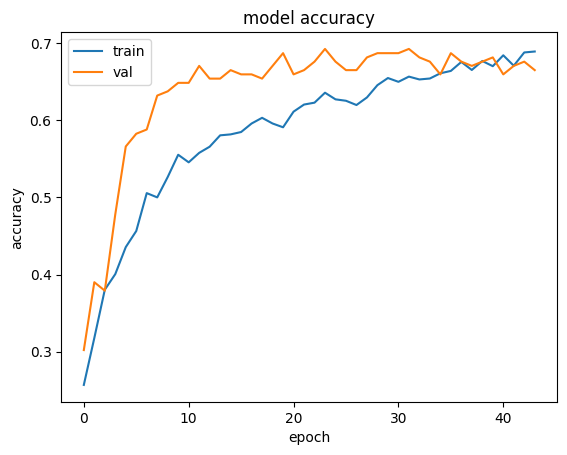

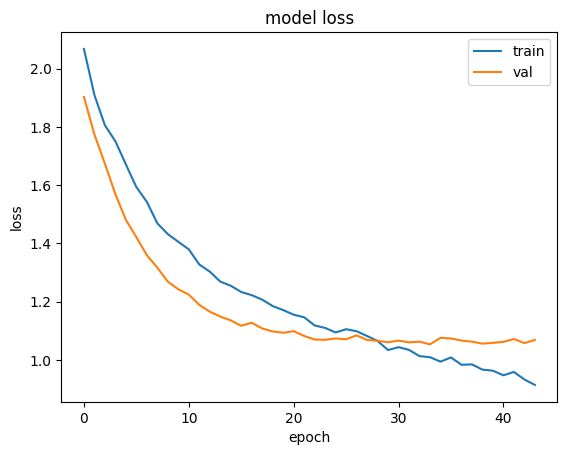

In [19]:
%matplotlib inline
import matplotlib.pyplot as plt


# summarize history for accuracy
plt.plot(history_text.history['categorical_accuracy'])
plt.plot(history_text.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history_text.history['loss'])
plt.plot(history_text.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [20]:
# store the predicted labels
y_pred_text = np.argmax(model_text.predict(X_val), -1)

print('\n===========Confusion Matrix===========\n')
print(confusion_matrix(np.array(Y_val).astype(int), y_pred_text))

print('\n===========Classification Report===========\n')
print(classification_report(np.array(Y_val).astype(int), y_pred_text))

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

===========Confusion Matrix===========

[[ 5  0  0  1  0  2  0  0  0]
 [ 0  9  1  2  0  1  0  0  1]
 [ 0  0 19  3  0  1  1  2  1]
 [ 1  2  3 46  0  1  0  0  2]
 [ 0  0  4  0  6  1  0  0  0]
 [ 0  0  2  9  1 14  0  0  2]
 [ 0  0  2  2  0  1  5  0  0]
 [ 0  0  0  2  0  2  0  6  0]
 [ 0  0  1  5  0  0  0  0 13]]

===========Classification Report===========

              precision    recall  f1-score   support

           0       0.83      0.62      0.71         8
           1       0.82      0.64      0.72        14
           2       0.59      0.70      0.64        27
           3       0.66      0.84      0.74        55
           4       0.86      0.55      0.67        11
           5       0.61      0.50      0.55        28
           6       0.83      0.50      0.62        10
           7       0.75      0.60      0.67        10
           8       0.68      0.68      0.68        19

    accuracy                           0.68       182
   macro

* The classification report demonstrates an important improvement in performance using a text-based model with MLPs compared to logistic regression, with an accuracy of ~68%.

### Use the outputs as input vectors
* We'll utilize the trained model to generate the probability distributions for the nine classes (calling the predict method for train and test domains) on both the training and test datasets. These distributions will then serve as additional features, to train another Multi-Layer Perceptron (MLP) model.
* By incorporating these probs as additional features, the new model can leverage this information to potentially improve its predictive performance since these distributions capture the model's confidence in its predictions for each class, providing insights that may enhance the overall accuracy and robustness of the new model.

In [21]:
y_probs_text_train = model_text.predict(X_train_all)
y_probs_text_test = model_text.predict(X_test)

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


## Create and incorporate graph-based features 
### Connectivity | In/Out-degrees
* Extracting information from the graph, such as node degrees and average neighbor degrees, provides valuable insights into the structural properties of the network surrounding the domains of interest.
* The in-degree and out-degree of nodes in the graph can indicate the level of influence a domain has within the network and how many other domains it is connected to.
* Average neighbor degree reflects the average degree of neighboring nodes for each domain, offering insights into the local connectivity patterns.


In [22]:
# Create a directed graph
G = nx.read_edgelist(data_path+'edgelist.txt', delimiter=' ', create_using=nx.DiGraph())

node_to_idx = dict()
for i, node in enumerate(G.nodes()):
    node_to_idx[node] = i
    
print('Number of nodes:', G.number_of_nodes())
print('Number of edges:', G.number_of_edges())

Number of nodes: 65208
Number of edges: 1642073


In [23]:
graph_feat_train = np.zeros((len(train_domains), 3))
avg_neig_deg = nx.average_neighbor_degree(G, nodes=train_domains)
for i in range(len(train_domains)):
    graph_feat_train[i,0] = G.in_degree(train_domains[i])
    graph_feat_train[i,1] = G.out_degree(train_domains[i])
    graph_feat_train[i,2] = avg_neig_deg[train_domains[i]]

# Create the test matrix. Use the same 3 features as above
graph_feat_test = np.zeros((len(test_domains), 3))
avg_neig_deg = nx.average_neighbor_degree(G, nodes=test_domains)
for i in range(len(test_domains)):
    graph_feat_test[i,0] = G.in_degree(test_domains[i])
    graph_feat_test[i,1] = G.out_degree(test_domains[i])
    graph_feat_test[i,2] = avg_neig_deg[test_domains[i]]

### Connectivity | Random Walks 

* Generate random walks for nodes in the graph by traversing the graph from randomly selected starting nodes, choosing neighboring nodes at each step.
* Represent each random walk sequence as a "text" document, where nodes visited in the random walk correspond to "words" in the text.
* Train a Skip-gram model (woc2vec) on the random walk sequences, treating them as "sentences," to learn embeddings for each node capturing the structural information of the graph.

In [24]:
def random_walk(G, node, walk_length):
    """ Starts from vertex "node" and performs a random walk of length "walk length". Returns a list of the visited vertices """
    walk = [node]

    for _ in range(walk_length-1):
        neighbors = list(G.neighbors(walk[-1]))
        if len(neighbors) > 0:
            neighbor = choice(neighbors)
            walk.append(neighbor)
        else:
            break

    walk = [str(node) for node in walk]
    return walk


def generate_walks(G, num_walks, walk_length):
    """ Runs "num_walks" random walks from each node, and returns a list of all random walk """ 
    walks = []

    for _ in range(num_walks):
        for node in G.nodes():
            walk = random_walk(G, node, walk_length)
            walks.append(walk)

    return walks

walks = generate_walks(G, 20, 40) #10
print(walks[0])

['blog.com.gr', 'aftodioikisi.gr']


In [25]:
# train a skip-gram model to vectorize the random walks for each node of the network
w2vec = Word2Vec(walks, vector_size=128, window=10, min_count=0, sg=1, workers=8, epochs=5)

In [26]:
# Create the training matrix. Each row corresponds to a web host.
graph_walks_train = np.zeros((len(train_domains), 128))
for i, domain in enumerate(train_domains):
    graph_walks_train[i,:] = w2vec.wv[domain]

# Create the test matrix. 
graph_walks_test = np.zeros((len(test_domains), 128))
for i, domain in enumerate(test_domains):
    graph_walks_test[i,:] = w2vec.wv[domain]

### Connectivity | Louvain algorithm to get community labels
* Convert the graph to undirected graph and partition the nodes into communities based on their connectivity patterns using Louvain algorithm

In [28]:
G_undirected = G.to_undirected()

# Run the Louvain algorithm
partition = community_louvain.best_partition(G_undirected, random_state=66)

In [29]:
train_comm = []
# For train domains
for domain in train_domains:
    train_comm.append(partition[domain])
train_comm = np.array(train_comm).reshape(len(train_comm),1)

test_comm = []
# For test domains
for domain in test_domains:
    test_comm.append(partition[domain])
test_comm = np.array(test_comm).reshape(len(test_comm),1)

### Concatenate the corresponding features and create a new feature input
* Combine the following to create the new X_train that will feed and fit a new MLP model
    * output of text/content-based model (1x9 probabilities distribution)
    * w2v embedding representing the neighbor of the node
    * the graph-related features about connectivity

In [30]:
X_train_new = np.concatenate((y_probs_text_train, graph_walks_train, graph_feat_train, train_comm), axis=1)
X_test_new = np.concatenate((y_probs_text_test, graph_walks_test, graph_feat_test, test_comm), axis=1)

In [31]:
X_train, X_val, Y_train, Y_val = train_test_split(X_train_new, y_train, test_size=0.1, stratify=y_train, random_state=66)

# Create one hot encondings for the target variable NNs to work
Y_train_1hot = to_categorical(Y_train, num_classes=9)
Y_val_1hot = to_categorical(Y_val, num_classes=9)

#### Scale the data and perform Logistic Regression
* Again, we first test a simple logistic regression to compare it with the baseline

In [32]:
scaler = StandardScaler()

# Fit the scaler on the training data
scaler.fit(X_train)

# Transform the training, validation, and test sets
X_scaled_train = scaler.transform(X_train)
X_scaled_val = scaler.transform(X_val)

In [33]:
# Initialize the logistic regression model
model_lr = LogisticRegression(max_iter=3000)

# Train the model
model_lr.fit(X_scaled_train, np.array(Y_train))

# Make predictions on the test set
y_val_pred = model_lr.predict(X_scaled_val)

print('\n===========Confusion Matrix===========\n')
print(confusion_matrix(Y_val, y_val_pred))

print('\n===========Classification Report===========\n')
print(classification_report(Y_val, y_val_pred))


===========Confusion Matrix===========

[[ 5  0  1  0  0  2  0  0  0]
 [ 0 11  0  1  0  1  0  0  1]
 [ 0  0 19  3  0  2  2  1  0]
 [ 1  0  5 37  0  6  1  2  3]
 [ 0  0  3  0  8  0  0  0  0]
 [ 1  1  0  6  1 14  1  0  4]
 [ 0  0  2  1  0  2  3  0  2]
 [ 0  0  0  0  0  1  0  9  0]
 [ 0  1  0  1  0  0  0  0 17]]

===========Classification Report===========

              precision    recall  f1-score   support

           0       0.71      0.62      0.67         8
           1       0.85      0.79      0.81        14
           2       0.63      0.70      0.67        27
           3       0.76      0.67      0.71        55
           4       0.89      0.73      0.80        11
           5       0.50      0.50      0.50        28
           6       0.43      0.30      0.35        10
           7       0.75      0.90      0.82        10
           8       0.63      0.89      0.74        19

    accuracy                           0.68       182
   macro avg       0.68      0.68      0.67   

* The model's performance improved significantly with these enhanced features compared to the benchmark Logistic Regression and achieves accuracy of 68%; Similar validation accuracy with the output of the MLP model 1

## Using MLPs 
* We train and test a second MLP model.

### Run Hyperparameter Tuning with Optuna
* We are using again Optuna to tune hyperparameters for our second model.
* We keep the same function that configures the model to be built with the same parameters to fine tune.

In [34]:
def build_MLP_model_tuning(trial):
    """
    Tunes a Multilayer Perceptron (MLP) model's architecture and hyperparameters using Optuna's trial object.
    """
    model = Sequential()

    layer_index = 0
    for i in range(trial.suggest_int('num_layers', 1, 4)):
        if layer_index == 0:
            units = trial.suggest_int(f'Hidden_units_{i}', 256, 1024, step=128)
            model.add(Dense(units=units, activation='relu', kernel_initializer='glorot_uniform', input_dim=X_train.shape[1])) #input included
            model.add(Dropout(trial.suggest_float(f'Dropout_layer_{i}', 0.1, 0.5, step=0.1)))
        else:
            units = trial.suggest_int(f'Hidden_units_{i}', 256, 1024, step=128)
            model.add(Dense(units=units, activation='relu', kernel_initializer='glorot_uniform'))
            model.add(Dropout(trial.suggest_float(f'Dropout_layer_{i}', 0.1, 0.5, step=0.1)))

        layer_index += 1

    # Add last layer that produces the logits
    model.add(Dense(units=9, activation='softmax', kernel_initializer='glorot_uniform', name='Output'))
    # Tune the learning rate for the optimizer
    learning_rate = trial.suggest_categorical('learning_rate', [1e-2, 1e-3, 1e-4])
    # Compile the model using categorical cross entropy loss (multiclass classification)
    model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=learning_rate), metrics=['categorical_accuracy'])

    return model


def objective(trial):
    """
    Evaluates the model's performance by optimizing validation loss.
    """

    # Sample batch size
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])

    # Wrap build_MLP_model_tuning function with Optuna's KerasPruningCallback
    model = build_MLP_model_tuning(trial)

    # Add early stopping to avoid overfitting
    early_stopping = EarlyStopping(monitor='val_loss', patience=5)

    # Train the model
    history = model.fit(
        X_scaled_train,
        Y_train_1hot,
        #validation_split=0.1,
        validation_data=(X_scaled_val, Y_val_1hot),
        epochs=100,
        batch_size=batch_size,
        callbacks=[early_stopping], #add early stopping to avoid overfitting, and also save execution time
        verbose=0
    )

    # Return the validation accuracy as the objective value to minimize
    return history.history['val_loss'][-1]

In [35]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2024-06-07 18:27:13,668] A new study created in memory with name: no-name-ad95b7d2-f4c8-4097-8341-e722737b1fe6
/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
[I 2024-06-07 18:27:24,059] Trial 0 finished with value: 0.7861682176589966 and parameters: {'batch_size': 128, 'num_layers': 3, 'Hidden_units_0': 384, 'Dropout_layer_0': 0.30000000000000004, 'Hidden_units_1': 256, 'Dropout_layer_1': 0.5, 'Hidden_units_2': 768, 'Dropout_layer_2': 0.30000000000000004, 'learning_rate': 0.0001}. Best is trial 0 with value: 0.7861682176589966.
[I 2024-06-07 18:27:33,105] Trial 1 finished with value: 0.7423121929168701 and parameters: {'batch_size': 32, 'num_layers': 1, 'Hidden_units_0': 768, 'Dropout_layer_0': 0.4, 'lea

Number of finished trials:  50
Best trial:
  Value:  0.7294769883155823
  Params: 
    batch_size: 128
    num_layers: 1
    Hidden_units_0: 896
    Dropout_layer_0: 0.30000000000000004
    learning_rate: 0.0001


### Train the best model from optuna results
* Compile the MLP model using the optimal hyperparameters
* Use Early stopping callback to avoid overfitting

In [36]:
model_deepwalk = build_MLP_model_tuning(study.best_trial)

print(model_deepwalk.summary())

early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=2, restore_best_weights=True)

history_deepwalk = model_deepwalk.fit(X_scaled_train, 
                        Y_train_1hot,
                        validation_data=(X_scaled_val, Y_val_1hot),
                        #validation_split=0.1,
                        batch_size=32,
                        epochs=100,
                        shuffle=True,
                        callbacks=[early_stopping])

Model: "sequential_101"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_190 (Dense)               │ (None, 896)            │       127,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_190 (Dropout)           │ (None, 896)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output (Dense)                  │ (None, 9)              │         8,073 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 135,305 (528.54 KB)

 Trainable params: 135,305 (528.54 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - categorical_accuracy: 0.2026 - loss: 2.1485 - val_categorical_accuracy: 0.5604 - val_loss: 1.6070
Epoch 2/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - categorical_accuracy: 0.5219 - loss: 1.5471 - val_categorical_accuracy: 0.6593 - val_loss: 1.2844
Epoch 3/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - categorical_accuracy: 0.6230 - loss: 1.2611 - val_categorical_accuracy: 0.6813 - val_loss: 1.1038
Epoch 4/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - categorical_accuracy: 0.6835 - loss: 1.0576 - val_categorical_accuracy: 0.7198 - val_loss: 0.9973
Epoch 5/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - categorical_accuracy: 0.7383 - loss: 0.9182 - val_categorical_accuracy: 0.7308 - val_loss: 0.9257
Epoch 6/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - categorical_accuracy: 0.7479 - loss: 0.8148 - val_categorical_accuracy: 0.7473 - val_loss: 0.8780
Epoch 7/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - categorical_accuracy: 0.7840 - loss:

### Evaluate performance

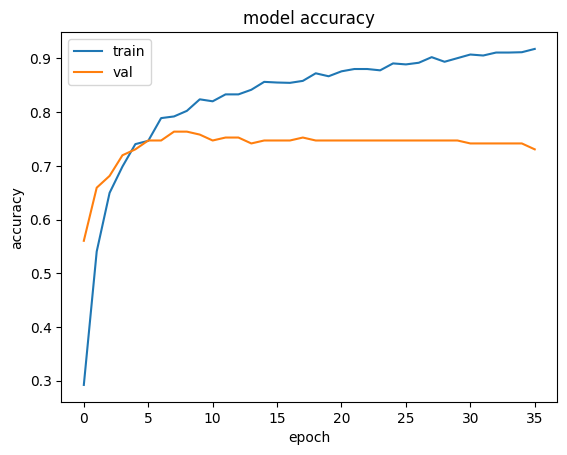

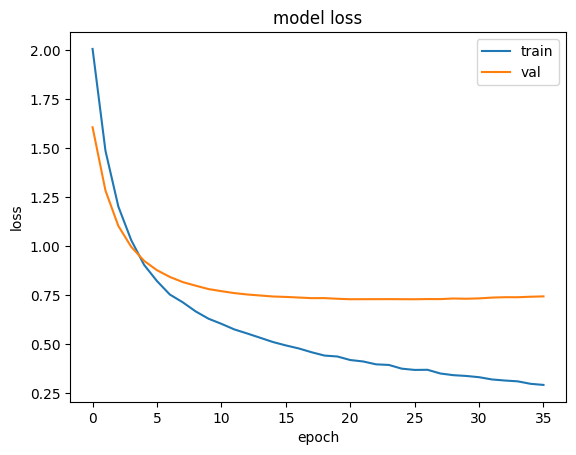

In [37]:
%matplotlib inline
import matplotlib.pyplot as plt


# summarize history for accuracy
plt.plot(history_deepwalk.history['categorical_accuracy'])
plt.plot(history_deepwalk.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history_deepwalk.history['loss'])
plt.plot(history_deepwalk.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [38]:
y_pred_deep = np.argmax(model_deepwalk.predict(X_scaled_val), -1)
print(classification_report(np.array(Y_val).astype(int), y_pred_deep))

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
              precision    recall  f1-score   support

           0       1.00      0.62      0.77         8
           1       1.00      0.86      0.92        14
           2       0.68      0.63      0.65        27
           3       0.75      0.85      0.80        55
           4       0.88      0.64      0.74        11
           5       0.57      0.61      0.59        28
           6       0.80      0.40      0.53        10
           7       0.82      0.90      0.86        10
           8       0.78      0.95      0.86        19

    accuracy                           0.75       182
   macro avg       0.81      0.72      0.75       182
weighted avg       0.76      0.75      0.74       182



* The graph-based MLP outperforms the previous MLP model, showcasing improved precision, recall, and F1-scores across classes, resulting in an overall accuracy boost to 75%. 
* However, there are signs of overfitting, indicated by a notable difference between the model's performance on the training data (training categorical accuracy of 92.30% with a loss of 0.2842) and its performance on unseen validation data (categorical accuracy of 73.08% and a higher loss of 0.7445)

### Use the outputs as input vectors
* Again, we are going to utilize this output produced for the train and test data as input to a Graph NN.
* Store the predicted probabilities by domain to extract the information later.

In [39]:
y_probs_graph_train = model_deepwalk.predict(scaler.transform(X_train_new))
y_probs_graph_test = model_deepwalk.predict(scaler.transform(X_test_new))

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [2]:
# create a dictionary to get later the correct values
train_domain_prob = dict(zip(train_domains, y_probs_graph_train))
test_domain_prob = dict(zip(test_domains, y_probs_graph_test))
domain_prob = {**train_domain_prob, **test_domain_prob}

## Graph Neural Networks

* In order to validate if the results can be further enhanced, we are going to test a Graph Neural Network. 
* We build a two-layer Graph Convolutional Network (GCN). Each layer computes new node representations by aggregating neighbor information. 
* The node data features/representations are derived from Word2Vec model trained with generated random walks, enriched further by incorporating probability distributions (the output of the previous model for train,val, and test nodes, and random for the rest), aiming to capture both local and global graph structure along with the contextual information.
* Graph convolution takes the weighted sum of the node features of a given node  and its neighbors (the gray nodes within the blue circle) to calculate updated node representation values of the node. Through this convolution operation, the node representation captures localized graph information.

In [43]:
class GNN(nn.Module):
    def __init__(self, n_feat, hidden_dim1, hidden_dim2, n_class, dropout):
        super().__init__()
        self.mp1 = GCNConv(n_feat, hidden_dim1)
        self.mp2 = GCNConv(hidden_dim1, hidden_dim2)

        self.fc = nn.Linear(hidden_dim2, n_class)
        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        # First GCN layer
        x = self.mp1(x, edge_index)
        x = self.relu(x)
        x = self.dropout(x)

        # Second GCN layer
        x = self.mp2(x, edge_index)
        x = self.relu(x)
        x = self.dropout(x)

        # Fully connected layer
        x = self.fc(x)

        # Log softmax for output probabilities
        return F.log_softmax(x, dim=1)

In [44]:
# Create tensor that stores edges
edge_index = torch.zeros(2, G.number_of_edges(), dtype=torch.long)
for i,edge in enumerate(G.edges()):
    edge_index[0,i] = node_to_idx[edge[0]]
    edge_index[1,i] = node_to_idx[edge[1]]

# Initialize the features of the nodes as random vectors of dimension 16
feature_dim = 128+9

# List to hold tensors
tensor_list = []
# Loop over the nodes to create tensors and add them to the list
for i, node in enumerate(G.nodes()):
    w2vec_tensor = torch.tensor(w2vec.wv[node]).reshape(1, 128)
    #par_cluster = torch.tensor([partition[node]]).reshape(1, 1)
    
    if node in train_domains + test_domains:
        domain_prob_tensor = torch.tensor(domain_prob[node]).reshape(1, 9) # get the probabilities distribution
        tensor = torch.cat((domain_prob_tensor, w2vec_tensor), dim=1) # Concatenate the tensors along dimension 1
    else:
        domain_prob_tensor = torch.rand(1, 9) # tensor with random numbers drawn from a uniform distribution on the interval
        tensor = torch.cat((domain_prob_tensor, w2vec_tensor), dim=1)
                
    # Append the tensor to the list
    tensor_list.append(tensor)

# Concatenate all tensors in the list to form a matrix
x = torch.cat(tensor_list, dim=0)

# Yields indices to split data into training and test sets
idx_train = [node_to_idx[node] for node in train_domains]
idx_test = [node_to_idx[node] for node in test_domains]

In [45]:
# Initialize device
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Hyperparameters
epochs = 150
n_hidden_1 = 64
n_hidden_2 = 128
lr = 0.01
dropout_rate = 0.4
n_class = 9

# Create data object
data = Data(x=x, edge_index=edge_index).to(device)

# Split training set into training and validation sets
idx_train, idx_val, Y_train, Y_val = train_test_split(idx_train, np.array(y_train).astype(int),
                                                      stratify=np.array(y_train).astype(int), test_size=0.1, random_state=66)

# Transform the numpy matrices/vectors to torch tensors
Y_train = torch.LongTensor(Y_train).to(device)
Y_val = torch.LongTensor(Y_val).to(device)
idx_train = torch.LongTensor(idx_train).to(device)
idx_val = torch.LongTensor(idx_val).to(device)
idx_test = torch.LongTensor(idx_test).to(device)


### GCN Training
* Train the model using the whole graph G
* Provide the indices for train and validation nodes.

In [46]:
# Creates the model and specifies the optimizer
model_GNN = GNN(feature_dim, n_hidden_1, n_hidden_2, n_class, dropout_rate).to(device)
optimizer = optim.Adam(model_GNN.parameters(), lr=lr)
loss_function = nn.CrossEntropyLoss()

# Train the model
best_val_loss = 100

train_losses = []
val_losses = []

for epoch in range(1, epochs+1):
    model_GNN.train()    
    optimizer.zero_grad()
    output = model_GNN(data)
    loss = loss_function(output[idx_train], Y_train)
    loss.backward()
    optimizer.step()

    model_GNN.eval()
    loss_val = 0
    output = model_GNN(data)
    loss_val = loss_function(output[idx_val], Y_val)

    # Remember best validation loss and save checkpoint
    is_best = loss_val <= best_val_loss
    best_val_loss = min(loss_val, best_val_loss)
    if is_best:
        torch.save({
            'state_dict': model_GNN.state_dict(),
            'optimizer' : optimizer.state_dict(),
        }, 'model_best.pth.tar')
    

    if epoch%10==0:
        print('Epoch: {:03d}, Train Loss: {:.7f}, Val Loss: {:.7f}'.format(epoch, loss, loss_val))
    
    train_losses.append(loss.detach().numpy())
    val_losses.append(loss_val.detach().numpy())


Epoch: 010, Train Loss: 1.7874802, Val Loss: 1.7478139
Epoch: 020, Train Loss: 1.4105903, Val Loss: 1.3341889
Epoch: 030, Train Loss: 1.1933875, Val Loss: 1.1847739
Epoch: 040, Train Loss: 1.1066774, Val Loss: 1.1399361
Epoch: 050, Train Loss: 1.0329919, Val Loss: 1.1036841
Epoch: 060, Train Loss: 0.9837345, Val Loss: 1.0561961
Epoch: 070, Train Loss: 0.9319724, Val Loss: 1.0334556
Epoch: 080, Train Loss: 0.8918031, Val Loss: 1.0049448
Epoch: 090, Train Loss: 0.8936018, Val Loss: 0.9884835
Epoch: 100, Train Loss: 0.8589173, Val Loss: 0.9575278
Epoch: 110, Train Loss: 0.8226768, Val Loss: 0.9450393
Epoch: 120, Train Loss: 0.8111351, Val Loss: 0.9392893
Epoch: 130, Train Loss: 0.7575815, Val Loss: 0.9218789
Epoch: 140, Train Loss: 0.7495112, Val Loss: 0.9398527
Epoch: 150, Train Loss: 0.7550061, Val Loss: 0.9162852


### Evaluate performance

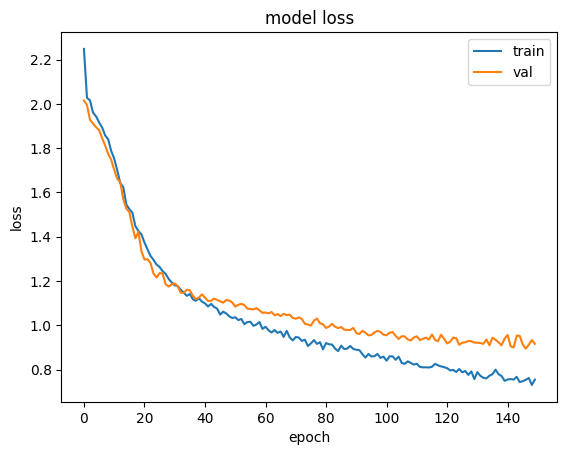

In [47]:
%matplotlib inline
import matplotlib.pyplot as plt

# summarize history for loss
plt.plot(train_losses)
plt.plot(val_losses)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [48]:
# Make predictions
model_GNN.eval()
checkpoint = torch.load('model_best.pth.tar')
model_GNN.load_state_dict(checkpoint['state_dict'])
output = model_GNN(data)
y_pred_gnn_val = torch.exp(output[idx_val]).detach().cpu().numpy()

In [49]:
y_pred_gnn_val = np.argmax(y_pred_gnn_val, -1)
print(classification_report(np.array(Y_val).astype(int), y_pred_gnn_val))

              precision    recall  f1-score   support

           0       0.57      0.50      0.53         8
           1       0.83      0.71      0.77        14
           2       0.73      0.70      0.72        27
           3       0.77      0.85      0.81        55
           4       0.82      0.82      0.82        11
           5       0.54      0.50      0.52        28
           6       0.44      0.40      0.42        10
           7       0.75      0.90      0.82        10
           8       0.78      0.74      0.76        19

    accuracy                           0.71       182
   macro avg       0.69      0.68      0.68       182
weighted avg       0.71      0.71      0.71       182



In [50]:
# Make predictions
model_GNN.eval()
checkpoint = torch.load('model_best.pth.tar')
model_GNN.load_state_dict(checkpoint['state_dict'])
output = model_GNN(data)
y_pred_gnn = torch.exp(output[idx_test]).detach().cpu().numpy()

* The GCN model achieved a train loss of 0.7550 and a validation loss of 0.9163, indicating lower overfitting compared to previous models. Despite a slightly lower validation accuracy of 71%, this reduced overfitting resulted in better generalization, leading to improved performance on the unseen test data submitted to Kaggle.

### Evaluation & Submission
* We extract the predictions and submit them to competition in kaggle

In [51]:
# Write predictions to a file
with open('sample_submission.csv', 'w') as csvfile:
    writer = csv.writer(csvfile, delimiter=',')
    lst = list()
    for i in range(9):
        lst.append('class_'+str(i))
    lst.insert(0, "domain_name")
    writer.writerow(lst)
    for i,test_host in enumerate(test_domains):
        lst = y_pred_gnn[i,:].tolist()
        lst.insert(0, test_host)
        writer.writerow(lst)

### Results 

* Our best model in Kaggle achieved a categorical loss of 0.9196 on the test domains, indicating some difficulty in generalizing well to unseen data compared to the training loss of 0.7550.